In [78]:

import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from torchvision.utils import make_grid

In [79]:
torch.manual_seed(0)
device=torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [117]:
def train(model, dataset, n_iter=100):
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
    criterion = nn.NLLLoss()
    model.train()
    
    for epoch in range(n_iter):
        for images, targets in dataset:
            optimizer.zero_grad()
            images = images.view(images.size(0), -1)
            out = model(images.to(device))
            loss = criterion(out, targets.to(device))
            loss.backward()
            optimizer.step()
        
        if epoch % 10 == 0:
            print('epoch: %3d loss: %.4f'%(epoch, loss))

def accuracy(model):
    model.eval()
    correct = 0
    for i in range(150):
        img1 = Image.open(f"../bombs/claymore/{i}.png")
        img2 = Image.open(f"../bombs/hcb/{i}.png")
        img3 = Image.open(f"../bombs/landmine/{i}.png")

        transform = transforms.Compose([
            transforms.Resize((45, 60)),
            transforms.ToTensor()
        ])

        input_tensor1 = transform(img1).unsqueeze(0).to(device)
        batch_size1 = input_tensor1.size(0)
        input_tensor1 = input_tensor1.view(batch_size1, -1)
        input_tensor2 = transform(img2).unsqueeze(0).to(device)
        batch_size2 = input_tensor2.size(0)
        input_tensor2 = input_tensor2.view(batch_size2, -1)
        input_tensor3 = transform(img3).unsqueeze(0).to(device)
        batch_size3 = input_tensor3.size(0)
        input_tensor3 = input_tensor3.view(batch_size3, -1)
        with torch.no_grad():
            output1 = model(input_tensor1)
            output2 = model(input_tensor2)
            output3 = model(input_tensor3)

        predicted_class1 = np.argmax(output1)
        predicted_class2 = np.argmax(output2)
        predicted_class3 = np.argmax(output3)
        if predicted_class1.item() == 0:
            correct += 1
        if predicted_class2.item() == 1:
            correct += 1
        if predicted_class3.item() == 2:
            correct += 1
        
    return correct / 450

In [81]:
data_dir = './trainset'
dataset = datasets.ImageFolder(data_dir,transform = transforms.Compose([
    transforms.Resize((45,60)),transforms.ToTensor()
]))

batch_size = 128
val_size = 500
train_size = len(dataset) - val_size 

train_data,val_data = random_split(dataset,[train_size,val_size])
print(f"Length of Train Data : {len(train_data)}")
print(f"Length of Validation Data : {len(val_data)}")

train_dl = DataLoader(train_data, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
val_dl = DataLoader(val_data, batch_size*2, num_workers = 4, pin_memory = True)

Length of Train Data : 2500
Length of Validation Data : 500


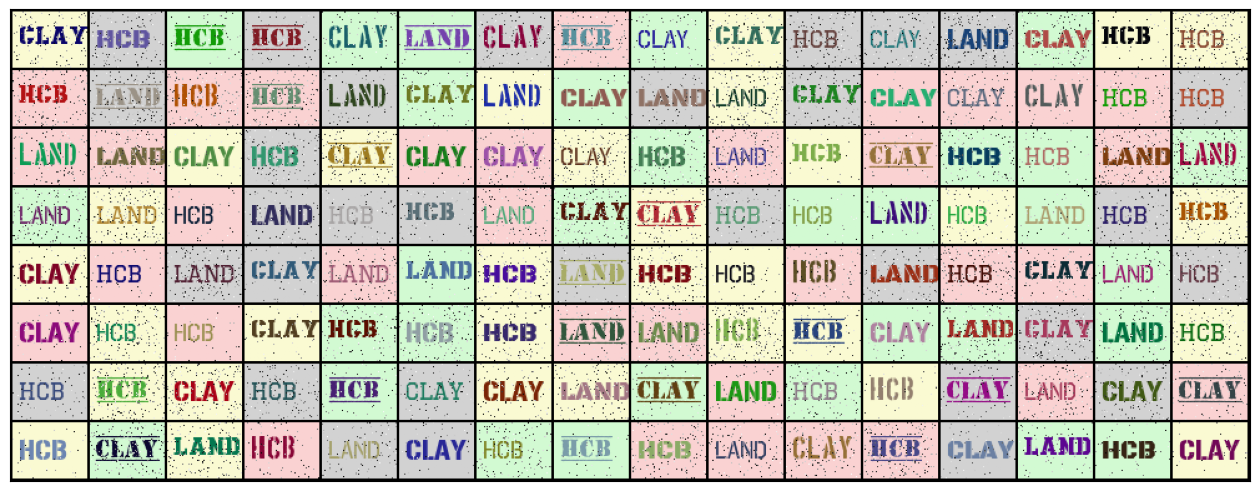

In [82]:
def show_batch(dl):
    """Plot images grid of single batch"""
    for images, labels in dl:
        fig,ax = plt.subplots(figsize = (16,12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
        break
        
show_batch(train_dl)

In [83]:
hidden_size=500

model = nn.Sequential(
    nn.Linear(45 * 60 * 3, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, 100), 
    nn.ReLU(),
    nn.Linear(100, 10), 
    nn.LogSoftmax(dim=-1)
).to(device)
train(model, train_dl)


epoch:   0 loss: 1.0964
epoch:  10 loss: 1.1759
epoch:  20 loss: 0.0971
epoch:  30 loss: 0.0276
epoch:  40 loss: 0.0077
epoch:  50 loss: 0.0058
epoch:  60 loss: 0.0045
epoch:  70 loss: 0.0052
epoch:  80 loss: 0.0041
epoch:  90 loss: 0.0019


In [84]:
torch.save(model, "neural_network_model.pth")

In [118]:
another_model = torch.load("neural_network_model.pth")
another_model.eval()
print(accuracy(another_model))

1.0
